# Moving Average (MA) Model

This should not be confused with *Moving Average* which is analogous to sliding window/Simple Moving Average (SMA). The MA model is it's own distinct concept, typically used in time series analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta

register_matplotlib_converters()

## Generating data

Most models don't really work with pure MA, typically is a component of models like ARMA or ARIMA. However, since we want to discuss MA in isolation, we will generate some data for it.

### $y_t = 50 + 0.4\varepsilon_{t-1} + 0.3\varepsilon_{t-2} + \varepsilon_t$
### $\varepsilon_t \sim N(0,1)$


In [2]:
errors = np.random.normal(0, 1, 400)

In [3]:
# Around 4 months of data
date_index = pd.date_range(start='2019-09-01', end='2020-01-01')

In [4]:
mu = 50
series = []
for t in range(1, len(date_index) + 1):
    series.append(mu + 0.4*errors[t - 1] + 0.3 * errors[t - 2] + errors[t])

In [6]:
series = pd.Series(series, index=date_index)
series = series.asfreq(pd.infer_freq(series.index))

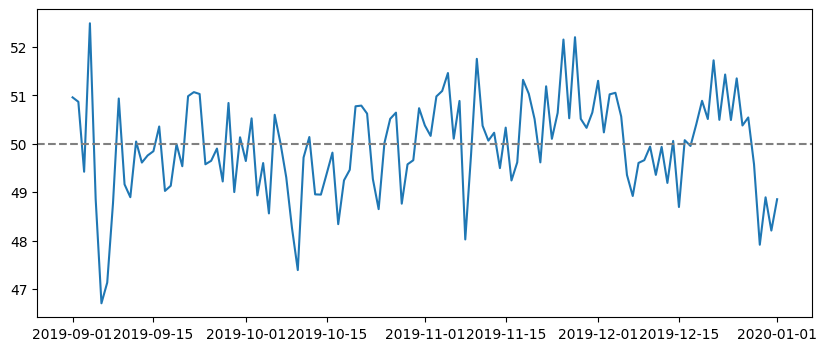

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(series)
plt.axhline(mu, linestyle='--', color='gray')

### ACF

<BarContainer object of 10 artists>

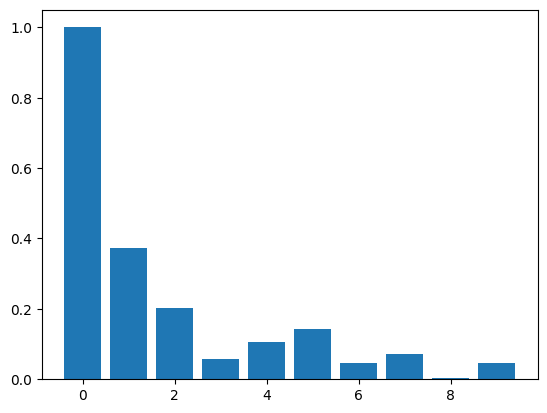

In [11]:
# ACF plot
acf_vals = acf(series)
num_lags = 10
plt.bar(range(num_lags), acf_vals[:num_lags])

ACF Plots are what is typically used to determine the order of the MA part of a model, whereas the PACF is typically used for the AR portion of the model (as a general rule of thumb).

Also, according to this plot, we might want to start with an MA(2) model.

### PACF

<BarContainer object of 21 artists>

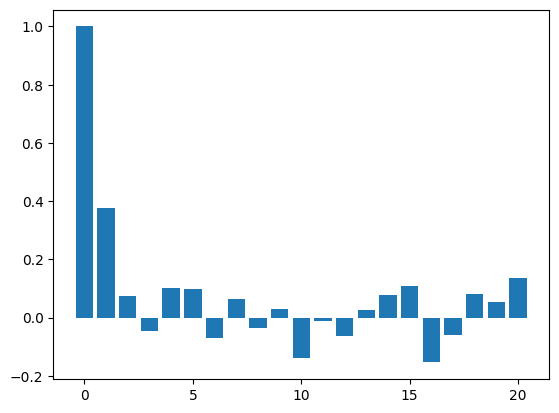

In [16]:
pacf_vals = pacf(series)
num_lags = 21
plt.bar(range(num_lags), pacf_vals[:num_lags])

### Important NOTE

The order of the MA model determines how far in the future it can predict. For instance, if we choose an MA(2) model, we can only predict 2 points into the future. After that the model will simply output the constant mean. 

I believe this is because we wouldn't have the error terms for the time steps further ahead, resulting in the epsilon values being 0 and reducing it to mu


## Generate training and testing data

In [17]:
train_end = datetime(2019, 12, 30)
test_end = datetime(2020, 1, 1)

train_data = series[:train_end]
test_data = series[train_end + timedelta(days=1):test_end]

## Fit ARIMA Model

Create an ARIMA model but zero out parts that are not MA

In [18]:
model = ARIMA(train_data, order=(0, 0, 2))

In [19]:
ma_model = model.fit()

In [20]:
print(ma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -162.946
Date:                Tue, 03 Sep 2024   AIC                            333.892
Time:                        00:29:08   BIC                            345.075
Sample:                    09-01-2019   HQIC                           338.434
                         - 12-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.9850      0.137    366.047      0.000      49.717      50.253
ma.L1          0.3659      0.082      4.457      0.000       0.205       0.527
ma.L2          0.2157      0.083      2.598      0.0

### We see that the predicted const, ma.L1, and ma.L2 are very close to the actual values from the actual data created via the equation: 

### $y_t = 50 + 0.4\varepsilon_{t-1} + 0.3\varepsilon_{t-2} + \varepsilon_t$
### $\varepsilon_t \sim N(0,1)$

### Thus the predicted model is

### $\hat{y}_t = 50 + 0.367\varepsilon_{t-1} + 0.216\varepsilon_{t-2}$

In [21]:
pred_start = test_data.index[0]
pred_end = test_data.index[-1]

In [22]:
predictions = ma_model.predict(start=pred_start, end=pred_end)

In [24]:
residuals = test_data - predictions

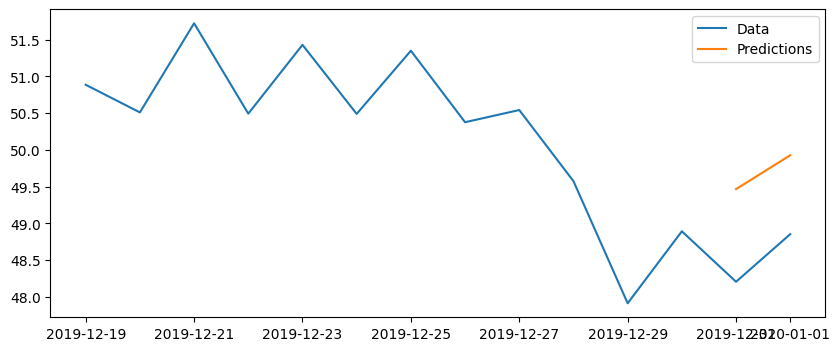

In [26]:
plt.figure(figsize=(10, 4))
plt.plot(series[-14:])
plt.plot(predictions)
plt.legend(('Data', 'Predictions'))

In [27]:
print("Mean Absolute Percent Error:", round(np.mean(abs(residuals/test_data)), 4))

Mean Absolute Percent Error: 0.0241


In [28]:
print("Root Mean Squared Error:", np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1.1712969416707977
